In [2]:
import os
os.chdir('../libraries/EAST')

In [3]:
os.getcwd()

'/home/vantuan5644/PycharmProjects/ReceiptOCR/libraries/EAST'

In [4]:
import torch
from torchvision import transforms
from PIL import Image, ImageDraw

# from config import PROJECT_ROOT
from model import EAST
import os
from dataset import get_rotate_mat
import numpy as np
import lanms


In [5]:

def resize_img(img):
	'''resize image to be divisible by 32
	'''
	w, h = img.size
	resize_w = w
	resize_h = h

	resize_h = resize_h if resize_h % 32 == 0 else int(resize_h / 32) * 32
	resize_w = resize_w if resize_w % 32 == 0 else int(resize_w / 32) * 32
	img = img.resize((resize_w, resize_h), Image.BILINEAR)
	ratio_h = resize_h / h
	ratio_w = resize_w / w

	return img, ratio_h, ratio_w


def load_pil(img):
	'''convert PIL Image to torch.Tensor
	'''
	t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
	return t(img).unsqueeze(0)


def is_valid_poly(res, score_shape, scale):
	'''check if the poly in image scope
	Input:
		res        : restored poly in original image
		score_shape: score map shape
		scale      : feature map -> image
	Output:
		True if valid
	'''
	cnt = 0
	for i in range(res.shape[1]):
		if res[0,i] < 0 or res[0,i] >= score_shape[1] * scale or \
           res[1,i] < 0 or res[1,i] >= score_shape[0] * scale:
			cnt += 1
	return True if cnt <= 1 else False


def restore_polys(valid_pos, valid_geo, score_shape, scale=4):
	'''restore polys from feature maps in given positions
	Input:
		valid_pos  : potential text positions <numpy.ndarray, (n,2)>
		valid_geo  : geometry in valid_pos <numpy.ndarray, (5,n)>
		score_shape: shape of score map
		scale      : image / feature map
	Output:
		restored polys <numpy.ndarray, (n,8)>, index
	'''
	polys = []
	index = []
	valid_pos *= scale
	d = valid_geo[:4, :] # 4 x N
	angle = valid_geo[4, :] # N,

	for i in range(valid_pos.shape[0]):
		x = valid_pos[i, 0]
		y = valid_pos[i, 1]
		y_min = y - d[0, i]
		y_max = y + d[1, i]
		x_min = x - d[2, i]
		x_max = x + d[3, i]
		rotate_mat = get_rotate_mat(-angle[i])

		temp_x = np.array([[x_min, x_max, x_max, x_min]]) - x
		temp_y = np.array([[y_min, y_min, y_max, y_max]]) - y
		coordidates = np.concatenate((temp_x, temp_y), axis=0)
		res = np.dot(rotate_mat, coordidates)
		res[0,:] += x
		res[1,:] += y

		if is_valid_poly(res, score_shape, scale):
			index.append(i)
			polys.append([res[0,0], res[1,0], res[0,1], res[1,1], res[0,2], res[1,2],res[0,3], res[1,3]])
	return np.array(polys), index


def get_boxes(score, geo, score_thresh=0.9, nms_thresh=0.2):
	'''get boxes from feature map
	Input:
		score       : score map from model <numpy.ndarray, (1,row,col)>
		geo         : geo map from model <numpy.ndarray, (5,row,col)>
		score_thresh: threshold to segment score map
		nms_thresh  : threshold in nms
	Output:
		boxes       : final polys <numpy.ndarray, (n,9)>
	'''
	score = score[0,:,:]
	xy_text = np.argwhere(score > score_thresh) # n x 2, format is [r, c]
	if xy_text.size == 0:
		return None

	xy_text = xy_text[np.argsort(xy_text[:, 0])]
	valid_pos = xy_text[:, ::-1].copy() # n x 2, [x, y]
	valid_geo = geo[:, xy_text[:, 0], xy_text[:, 1]] # 5 x n
	polys_restored, index = restore_polys(valid_pos, valid_geo, score.shape)
	if polys_restored.size == 0:
		return None

	boxes = np.zeros((polys_restored.shape[0], 9), dtype=np.float32)
	boxes[:, :8] = polys_restored
	boxes[:, 8] = score[xy_text[index, 0], xy_text[index, 1]]
	boxes = lanms.merge_quadrangle_n9(boxes.astype('float32'), nms_thresh)
	return boxes


def adjust_ratio(boxes, ratio_w, ratio_h):
	'''refine boxes
	Input:
		boxes  : detected polys <numpy.ndarray, (n,9)>
		ratio_w: ratio of width
		ratio_h: ratio of height
	Output:
		refined boxes
	'''
	if boxes is None or boxes.size == 0:
		return None
	boxes[:,[0,2,4,6]] /= ratio_w
	boxes[:,[1,3,5,7]] /= ratio_h
	return np.around(boxes)


def detect(img, model, device):
	'''detect text regions of img using model
	Input:
		img   : PIL Image
		model : detection model
		device: gpu if gpu is available
	Output:
		detected polys
	'''
	img, ratio_h, ratio_w = resize_img(img)
	with torch.no_grad():
		score, geo = model(load_pil(img).to(device))
	boxes = get_boxes(score.squeeze(0).cpu().numpy(), geo.squeeze(0).cpu().numpy())
	return adjust_ratio(boxes, ratio_w, ratio_h)


def plot_boxes(img, boxes):
	'''plot boxes on image
	'''
	if boxes is None:
		return img

	draw = ImageDraw.Draw(img)
	for box in boxes:
		draw.polygon([box[0], box[1], box[2], box[3], box[4], box[5], box[6], box[7]], outline=(0,255,0))
	return img


def detect_dataset(model, device, test_img_path, submit_path):
	'''detection on whole dataset, save .txt results in submit_path
	Input:
		model        : detection model
		device       : gpu if gpu is available
		test_img_path: dataset path
		submit_path  : submit result for evaluation
	'''
	img_files = os.listdir(test_img_path)
	img_files = sorted([os.path.join(test_img_path, img_file) for img_file in img_files])

	for i, img_file in enumerate(img_files):
		print('evaluating {} image'.format(i), end='\r')
		boxes = detect(Image.open(img_file), model, device)
		seq = []
		if boxes is not None:
			seq.extend([','.join([str(int(b)) for b in box[:-1]]) + '\n' for box in boxes])
		with open(os.path.join(submit_path, 'res_' + os.path.basename(img_file).replace('.jpg','.txt')), 'w') as f:
			f.writelines(seq)

In [54]:
model_path = 'pths/east_vgg16.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EAST().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()


EAST(
  (extractor): extractor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=

In [55]:
img_path = os.path.join('/home/vantuan5644/PycharmProjects/ReceiptOCR/datasets/OCR/product_attributes/img_2_padded_1.jpg')


In [56]:
import matplotlib.pyplot as plt

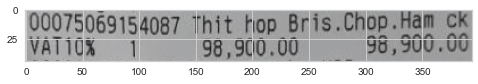

In [57]:
img = Image.open(img_path)

plt.imshow(img)

In [58]:
boxes = detect(img, model, device)
plot_img = plot_boxes(img, boxes)

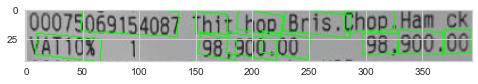

In [59]:
plt.imshow(plot_img)

In [60]:
polygons = boxes[:,:-1]

In [134]:
polygon = polygons[0].reshape(-1, 2)
polygon

array([[ 50.,  -4.],
       [135.,   1.],
       [134.,  23.],
       [ 49.,  18.]], dtype=float32)

In [135]:
top_left = polygon[np.argmin(np.sum(polygon, axis=1))]
right_bottom = polygon[np.argmax(np.sum(polygon, axis=1))]

print(top_left, right_bottom)

[50. -4.] [134.  23.]


In [145]:
def get_reduced_polygons(polygons):
    top_left_points = []
    right_bottom_points = []

    for polygon in polygons:
        polygon = polygon.reshape(-1, 2)
        top_left = polygon[np.argmin(np.sum(polygon, axis=1))]
        right_bottom = polygon[np.argmax(np.sum(polygon, axis=1))]
#         reduced_polygons.append(np.array([top_left, right_bottom]))
        top_left_points.append(np.array([top_left]))
        right_bottom_points.append(np.array([right_bottom]))

    return np.vstack(top_left_points), np.vstack(right_bottom_points)

In [146]:
tl, rb = get_reduced_polygons(polygons)

In [147]:
tl

array([[ 50.,  -4.],
       [ 10.,  20.],
       [329.,  17.],
       [229.,  -2.],
       [179.,  19.],
       [297.,  20.],
       [188.,  -2.],
       [209.,  18.],
       [154.,  20.],
       [369.,  17.],
       [150.,   1.],
       [281.,   1.]], dtype=float32)

In [139]:
tl[:, 1] = np.array(list(map(lambda x: max(0, x), tl[:, 1])))


In [140]:
import matplotlib.pyplot as plt

(array([3., 0., 2., 0., 0., 0., 0., 0., 2., 5.]),
 array([-4. , -1.6,  0.8,  3.2,  5.6,  8. , 10.4, 12.8, 15.2, 17.6, 20. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

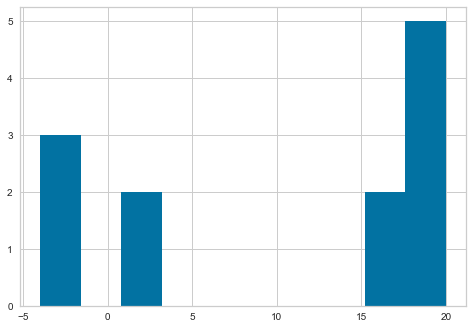

In [148]:
plt.hist(tl[:,1])

In [79]:
X = tl[:,1].reshape(-1, 1)

In [144]:
def find_optimal_k(X, K=range(1, 5), visualize=True):
    distortions = [] 

    for k in K: 
        #Building and fitting the model 
        kmeanModel = KMeans(n_clusters=k).fit(X) 
        kmeanModel.fit(X)     

        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                          'euclidean'),axis=1)) / X.shape[0]) 
    if visualize:
        plt.plot(K, distortions, 'bx-') 
        plt.xlabel('Values of K') 
        plt.ylabel('Distortion') 
        plt.title('The Elbow Method using Distortion') 
        plt.show()
    distortions = np.array(distortions)

In [83]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


/home/vantuan5644/anaconda3/envs/ReceiptOCR/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/vantuan5644/anaconda3/envs/ReceiptOCR/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/vantuan5644/anaconda3/envs/ReceiptOCR/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


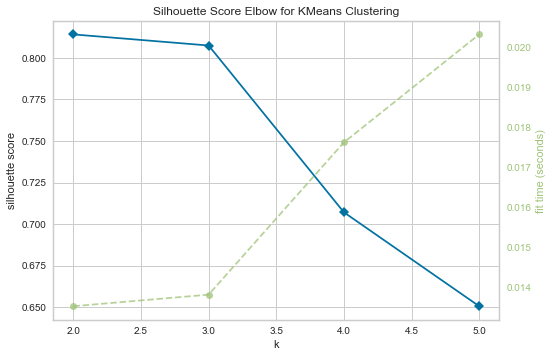

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [143]:
X = rb[:,1].reshape(-1, 1)
model = KElbowVisualizer(KMeans(), k=5, metric='silhouette')
model.fit(X)
model.show()

In [149]:
counts, values = np.histogram(tl[:,1])
print(counts, values, sep='\n')

[3 0 2 0 0 0 0 0 2 5]
[-4.  -1.6  0.8  3.2  5.6  8.  10.4 12.8 15.2 17.6 20. ]


In [150]:
np.nonzero(counts)[0]

array([0, 2, 8, 9])

In [151]:
np.arange(len(counts))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [152]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return np.array(list(zip(edges, edges)))

In [153]:
ranges(np.nonzero(counts)[0])

array([[0, 0],
       [2, 2],
       [8, 9]])

In [90]:
left_borders = values[ranges(np.nonzero(counts)[0])[:,0]]
left_borders

array([ 0., 16.], dtype=float32)

(array([1., 1., 3., 0., 0., 0., 0., 3., 0., 4.]),
 array([17. , 19.8, 22.6, 25.4, 28.2, 31. , 33.8, 36.6, 39.4, 42.2, 45. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

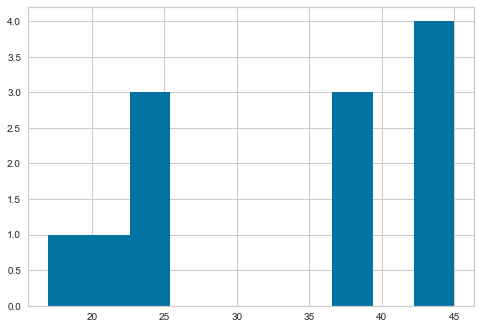

In [91]:
plt.hist(rb[:,1])

In [92]:
counts, values = np.histogram(rb[:,1])
print(counts, values, sep='\n')

[1 1 3 0 0 0 0 3 0 4]
[17.  19.8 22.6 25.4 28.2 31.  33.8 36.6 39.4 42.2 45. ]


In [93]:
np.nonzero(counts)[0]

array([0, 1, 2, 7, 9])

In [94]:
np.arange(len(counts))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [95]:
ranges(np.nonzero(counts)[0])

array([[0, 2],
       [7, 7],
       [9, 9]])

In [98]:
right_borders = values[ranges(np.nonzero(counts)[0])[:,1]]
right_borders

array([22.6, 36.6, 42.2], dtype=float32)

In [99]:
left_borders = np.floor(left_borders).astype(int)
left_borders = np.array(list(map(lambda x: max(0, x), left_borders)))
left_borders

array([ 0, 16])

In [100]:
right_borders = np.ceil(right_borders).astype(int)
right_borders = np.array(list(map(lambda x: max(0, x), right_borders)))

right_borders

array([23, 37, 43])

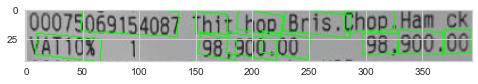

In [101]:
plt.imshow(plot_img)

In [102]:
import cv2

In [103]:
tuple(np.random.choice(range(256), size=3))

(70, 183, 209)

In [104]:
colors = [(255, 0, 0), (0, 255, 0), [0, 0, 255]]

In [113]:
min(len(left_borders), len(right_borders))

2

In [129]:
img = plt.imread(img_path)
x_min = 0
x_max = img.shape[1]

rows = []
row_orders = range(min(len(left_borders), len(right_borders)))

for i in row_orders:
    rows.append(img[left_borders[i]:right_borders[i], x_min:x_max])
#     img = cv2.rectangle(img, (x_min, left_borders[i]), (x_max, right_borders[i]), colors[i])



In [130]:
len(rows)

2

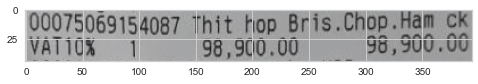

In [131]:
plt.imshow(img)

import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg


config = Cfg.load_config_from_name('vgg_transformer')


config['weights'] = '/home/vantuan5644/PycharmProjects/ReceiptOCR/weights/vietocr/transformerocr.pth'
# config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'

config['cnn']['pretrained'] = True
config['device'] = 'cuda:0'
config['predictor']['beamsearch'] = False


detector = Predictor(config)


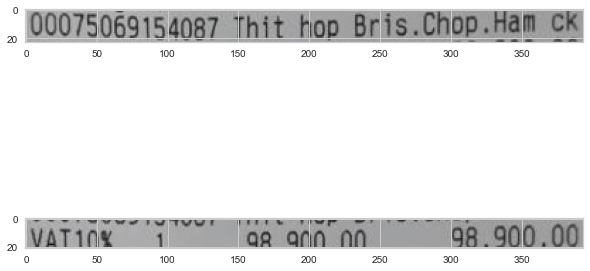

In [132]:
fig, ax = plt.subplots(nrows=len(rows), ncols=1, figsize=(10, 7))

for i, row in enumerate(rows):
    ax[i].imshow(row)
    img = Image.fromarray(row)
#     s = detector.predict(img)
#     ax[i].title.set_text(s)
plt.show()
